<h1 style="text-align:center"> Posterior predictive sampling in pymc3 </h1>

<h2 style="text-align:center"> Luciano Paz </h2>

<h4 style="text-align:center; width: 90%; margin-left: 5%; padding-bottom: 4%">
Some recipes to dodge shape problems that usually come up with posterior predictive sampling
</h4>
<div style="width: 50%; float: left; text-align: center; margin-left: 20%;">
    <p style="text-align: center">
    <img style="display:inline-block; width: 12%; vertical-align:middle;" src="https://raw.githubusercontent.com/pymc-devs/pymc3/master/docs/logos/PyMC3.png"> PyMC core maintainer
    </p>
</div>
<div style="margin-left: 70%; width: 20%;">
    <img style="float: right; width: 100%; border-radius: 20%; vertical-align:middle;" src="https://raw.githubusercontent.com/lucianopaz/my_website_source/master/content/authors/lucianopaz/avatar.jpg">
</div>
<div style="margin-top: 15%;">
    Presentation notebook available at <a href="https://github.com/lucianopaz/pymcon/blob/master/source/Presentation.ipynb">https://github.com/lucianopaz/pymcon/blob/master/source/Presentation.ipynb</a>
</div>


## Some background

- __Posterior predictive distributions__: The probability of certain new values given the data we have seen so far.
- We want PyMC to be user friendly so `sample_posterior_predictive` samples from this distribution.
- PyMC3 was first designed for inference, posterior predictive came later and has some problems.

## What's this about?

- Typical situations where `pymc3` fails to sample from the posterior predictive.
- Why it fails and how that's related to shape problems.
- How to handle these cases and make `sample_posterior_predictive` work.

In [1]:
import numpy as np
from theano import tensor as tt
import pymc3 as pm
import arviz as az
from matplotlib import pyplot as plt

RANDOM_SEED = 8290
np.random.seed(RANDOM_SEED)

## Simple model without posterior predictive problems

A linear regression:

$$
slope \sim Normal(0, 10) \\
intercept \sim Normal(0, 10) \\
\vec{\mu} = slope\, \vec{x} + intercept \\
observed \sim Normal(\vec{\mu}, 1) \\
$$

In [2]:
true_slope = 1
true_intercept = 5

Now we create some train and test data

In [3]:
x_train1 = np.linspace(-1, 2, 21)
y_train1 = (
    true_slope * x_train1 +
    true_intercept +
    np.random.randn(*x_train1.shape)
)

In [4]:
x_test1 = np.linspace(-3, 5, 10)
y_test1 = (
    true_slope * x_test1 +
    true_intercept +
    np.random.randn(*x_test1.shape)
)

In [5]:
coords1 = {"obs_ind": np.arange(len(x_train1))}

In [6]:
with pm.Model(coords=coords1) as simple_model:
    regressor = pm.Data("x", x_train1, dims="obs_ind")
    slope = pm.Normal("slope", 0, 10)
    intercept = pm.Normal("intercept", 0, 10)
    mu = slope * regressor + intercept
    output = pm.Data("y", y_train1)
    pm.Normal("observed", mu=mu, sigma=1, observed=output, dims="obs_ind")
    
    prior = pm.sample_prior_predictive()
    trace = pm.sample(tune=2000, random_seed=RANDOM_SEED)
    ppc = pm.fast_sample_posterior_predictive(trace)
    simple_idata = az.from_pymc3(trace=trace, prior=prior, posterior_predictive=ppc)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [intercept, slope]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 4 seconds.


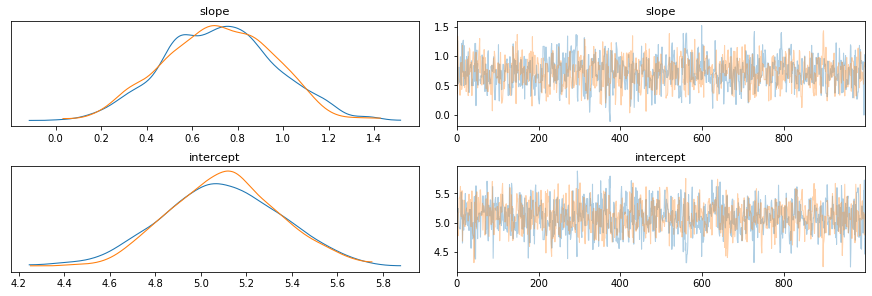

In [7]:
az.plot_trace(simple_idata);

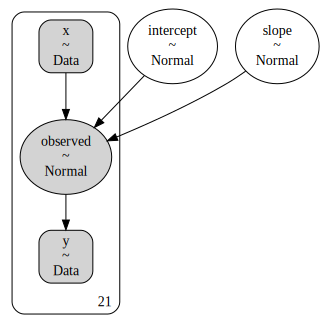

In [8]:
pm.model_to_graphviz(simple_model)

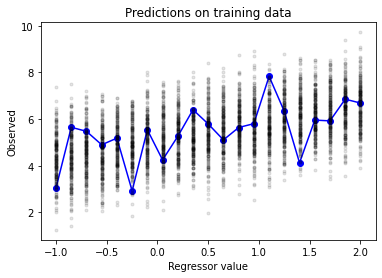

In [9]:
fig, ax = plt.subplots(1, 1)
ax.plot(x_train1, y_train1, "-ob")
ax.plot(x_train1, ppc["observed"][::10].T, ".k", alpha=0.1)
ax.set_xlabel("Regressor value")
ax.set_ylabel("Observed")
ax.set_title("Predictions on training data");

#### Lets make some predictions on new data

- Added difficulty: test data has different shape than training data

In [10]:
with simple_model:
    pm.set_data(
        dict(
            x=x_test1,
            y=y_test1,
        )
    )
    ppc2 = pm.fast_sample_posterior_predictive(simple_idata)

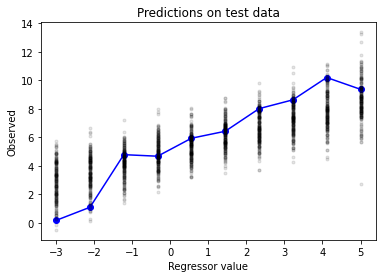

In [11]:
fig, ax = plt.subplots(1, 1)
ax.plot(x_test1, y_test1, "-ob")
ax.plot(x_test1, ppc2["observed"][::10].T, ".k", alpha=0.1)
ax.set_xlabel("Regressor value")
ax.set_ylabel("Observed")
ax.set_title("Predictions on test data");

### Things worked fine but...

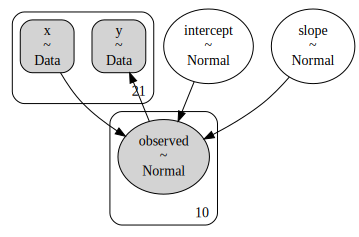

In [12]:
pm.model_to_graphviz(simple_model)

It's actually not so bad. The `pm.Data`'s dshape is only ever used for model_to_graphviz so it has no other consequence. 

## Shape problems creep in

![A shape problem would eat you and everyone you cared about](https://i.redd.it/oixpf3vlye7z.jpg)

Troy McClure: _Don't kid yourself Jimmy! If a shape problem ever got the chance, it'd eat you and everyone you care about!_

## Shape problems creep in

- Our distributions __are not theano tensors__
- Distribution shape __is not inferred from the parameters__
- Distribution shape __is detached from any change performed by `set_data`__

Things get messy as soon as some distribution's shape depends on variable data

#### A model with an unknown latent label per data point

$$
slope_{k} \sim Normal(0, 10) \\
intercept \sim Normal(0, 10) \\
label_{i} \sim Categorical(\vec{p}) \\
\mu_{i} = slope_{label_{i}}\, x_{i} + intercept \\
observed \sim Normal(\vec{\mu}, 1) \\
$$

In [13]:
component_probability = np.array([0.3, 0.7])
n_components = len(component_probability)

In [14]:
true_slopes = np.arange(n_components) * 2 + 1
true_intercept = 5

Now we create the model's train and test data

In [15]:
x_train2 = np.linspace(-1, 2, 21)
label_train2 = np.random.choice(
    n_components, p=component_probability, size=x_train2.shape
)
y_train2 = (
    true_slopes[label_train2] * x_train2 +
    true_intercept +
    np.random.randn(*x_train1.shape)
)
coords2 = {"obs_ind": np.arange(len(x_train2)), "component": np.arange(n_components)}

In [16]:
x_test2 = np.linspace(-3, 5, 10)
label_test2 = np.random.choice(
    n_components, p=component_probability, size=x_test2.shape
)
y_test2 = (
    true_slopes[label_test2] * x_test2 +
    true_intercept +
    np.random.randn(*x_test2.shape)
)

In [17]:
with pm.Model(coords=coords2) as latent_label_model:
    regressor = pm.Data("x", x_train2, dims="obs_ind")
    label = pm.Categorical("label", p=component_probability, dims="obs_ind")
    slope = pm.Normal(
        "slope",
        0,
        10,
        dims="component",
        transform=pm.transforms.Ordered(),
        testval=np.arange(len(coords2["component"])),
    )
    intercept = pm.Normal("intercept", 0, 10)
    mu = slope[label] * regressor + intercept
    output = pm.Data("y", y_train2)
    observed = pm.Normal("observed", mu=mu, sigma=1, observed=output, dims="obs_ind")

In [18]:
with latent_label_model:
    prior = pm.sample_prior_predictive()
    trace = pm.sample(tune=3000, random_seed=RANDOM_SEED)
    ppc = pm.fast_sample_posterior_predictive(trace)
    latent_label_idata = az.from_pymc3(trace=trace, prior=prior, posterior_predictive=ppc)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>BinaryGibbsMetropolis: [label]
>NUTS: [intercept, slope]


Sampling 2 chains for 3_000 tune and 1_000 draw iterations (6_000 + 2_000 draws total) took 15 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


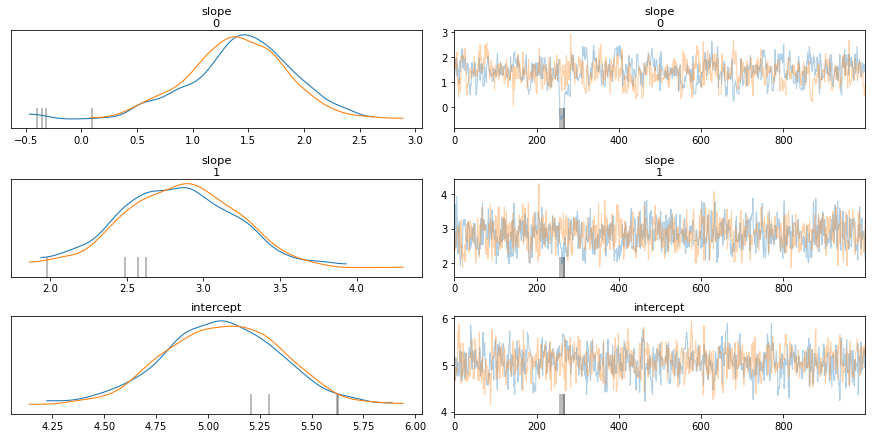

In [19]:
az.plot_trace(latent_label_idata, var_names=["slope", "intercept"]);

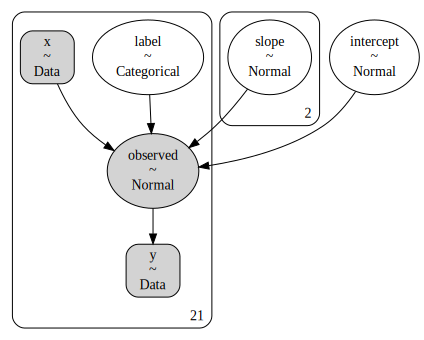

In [20]:
pm.model_to_graphviz(latent_label_model)

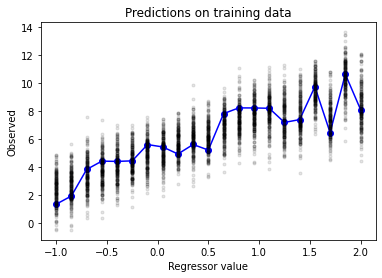

In [21]:
fig, ax = plt.subplots(1, 1)
ax.plot(x_train2, y_train2, "-ob")
ax.plot(x_train2, ppc["observed"][::10].T, ".k", alpha=0.1)
ax.set_xlabel("Regressor value")
ax.set_ylabel("Observed")
ax.set_title("Predictions on training data");

### But what happens on the test data?

In [22]:
with latent_label_model:
    pm.set_data(
        dict(
            x=x_test2,
            y=y_test2,
        )
    )
    try:
        ppc2 = pm.sample_posterior_predictive(latent_label_idata)
    except Exception as e:
        print(f"{e.__class__.__name__}: {e}")

ValueError: Input dimension mis-match. (input[0].shape[0] = 21, input[1].shape[0] = 10)
Apply node that caused the error: Elemwise{Composite{((i0 * i1) + i2)}}[(0, 0)](AdvancedSubtensor1.0, x, InplaceDimShuffle{x}.0)
Toposort index: 2
Inputs types: [TensorType(float64, vector), TensorType(float64, vector), TensorType(float64, (True,))]
Inputs shapes: [(21,), (10,), (1,)]
Inputs strides: [(8,), (8,), (8,)]
Inputs values: ['not shown', 'not shown', array([4.88740254])]
Outputs clients: [['output']]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.


### But why?

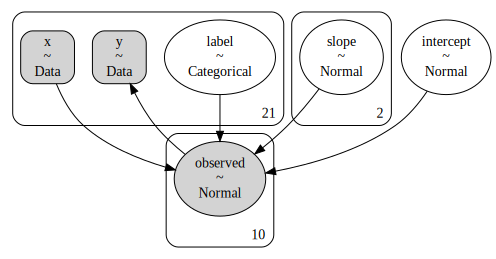

In [23]:
pm.model_to_graphviz(latent_label_model)

#### `pm.set_data` doesn't change `label`'s shape!!!

## What if we try to marginalize `label` out of the model?

$$
slope_{k} \sim Normal(0, 10) \\
intercept \sim Normal(0, 10) \\
label_{i} \sim Categorical(\vec{p}) \\
\mu_{i,k} = slope_{k}\, x_{i} + intercept \\
observed \sim NormalMixture(\vec{p}, \mu, 1) \\
$$

In [24]:
with pm.Model(coords=coords2) as scalar_mixture_model:
    regressor = pm.Data("x", x_train2, dims="obs_ind")
    slope = pm.Normal(
        "slope",
        0,
        10,
        dims="component",
        transform=pm.transforms.Ordered(),
        testval=np.arange(len(coords2["component"])),
    )
    intercept = pm.Normal("intercept", 0, 10)
    mu = slope * regressor[..., None] + intercept
    output = pm.Data("y", y_train2)
    observed = pm.NormalMixture(
        "observed",
        w=component_probability,
        mu=mu,
        sigma=1,
        observed=output,
        comp_shape=(len(coords2["obs_ind"]), len(coords2["component"])),
        dims="obs_ind",
    )

In [25]:
with scalar_mixture_model:
    prior = pm.sample_prior_predictive()
    trace = pm.sample(tune=3000, random_seed=RANDOM_SEED)
    ppc = pm.fast_sample_posterior_predictive(trace)
    scalar_mixture_idata = az.from_pymc3(trace=trace, prior=prior, posterior_predictive=ppc)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [intercept, slope]


Sampling 2 chains for 3_000 tune and 1_000 draw iterations (6_000 + 2_000 draws total) took 8 seconds.
The acceptance probability does not match the target. It is 0.886347674009575, but should be close to 0.8. Try to increase the number of tuning steps.


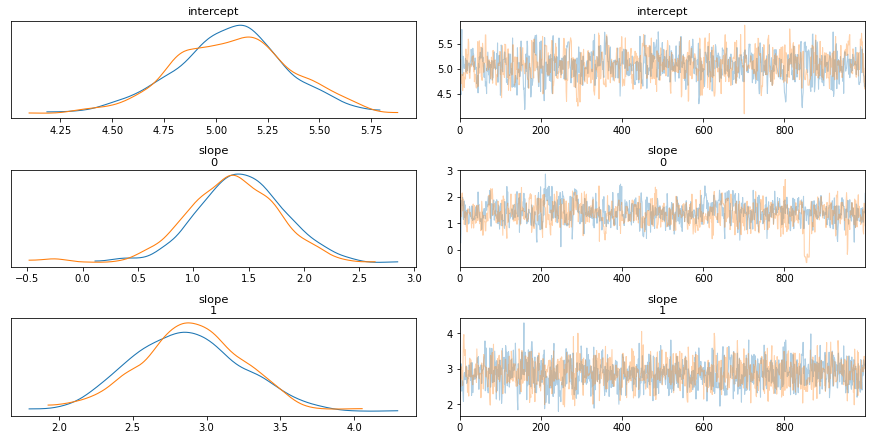

In [26]:
az.plot_trace(scalar_mixture_idata);

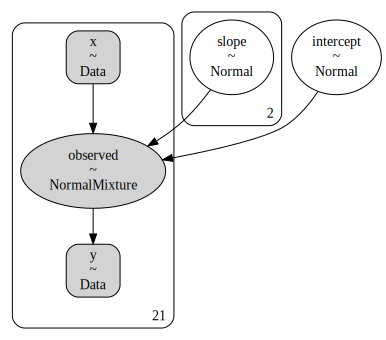

In [27]:
pm.model_to_graphviz(scalar_mixture_model)

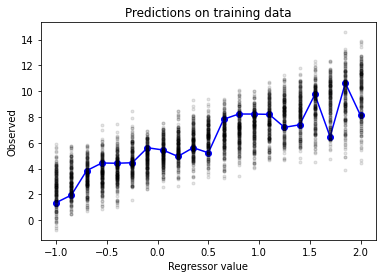

In [28]:
fig, ax = plt.subplots(1, 1)
ax.plot(x_train2, y_train2, "-ob")
ax.plot(x_train2, ppc["observed"][::10].T, ".k", alpha=0.1)
ax.set_xlabel("Regressor value")
ax.set_ylabel("Observed")
ax.set_title("Predictions on training data");

### But what happens with the test data?

In [29]:
with scalar_mixture_model:
    pm.set_data(
        dict(
            x=x_test2,
            y=y_test2,
        )
    )
    try:
        ppc2 = pm.sample_posterior_predictive(scalar_mixture_idata)
    except Exception as e:
        print(f"{e.__class__.__name__}: {e}")

ValueError: Cannot broadcast provided shapes (10, 2), (), (21, 2) given size: (1,)


### But why?

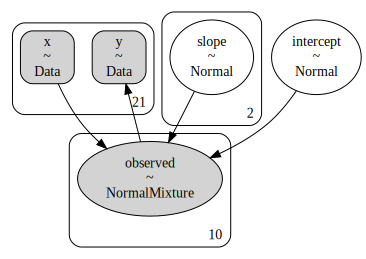

In [30]:
pm.model_to_graphviz(scalar_mixture_model)

- __NOT APPARENT FROM THE GRAPH!__
- The Mixture's __component distributions shape does not change__
- It's set when the distribution is constructed

## What to do?

![Try not to cry](https://i.kym-cdn.com/entries/icons/original/000/012/073/7686178464_fdc8ea66c7.jpg)

## Or...

## Functional approach

### We need to define a factory function to make models on new data

Pros:

- We can work around shape problems for posterior predictive sampling
- Can change any aspect of the model based on new data

Cons:

- Manual tunning
- Repeated model compilation
- Potential need to remove entries from posterior trace
- Added overhead of plotting
- __We shouldn't have to do this...__

In [31]:
def scalar_mixture_model_factory(coords, x, y):
    with pm.Model(coords=coords) as model:
        regressor = pm.Data("x", x, dims="obs_ind")
        slope = pm.Normal(
            "slope",
            0,
            10,
            dims="component",
            transform=pm.transforms.Ordered(),
            testval=np.arange(len(coords["component"])),
        )
        intercept = pm.Normal("intercept", 0, 10)
        mu = slope * regressor[..., None] + intercept
        output = pm.Data("y", y)
        observed = pm.NormalMixture(
            "observed",
            w=component_probability,
            mu=mu,
            sigma=1,
            observed=output,
            comp_shape=(len(coords["obs_ind"]), len(coords["component"])),
            dims="obs_ind",
        )
    return model

In [32]:
with scalar_mixture_model_factory(coords2, x_train2, y_train2) as mix_model:
    prior = pm.sample_prior_predictive()
    trace = pm.sample(tune=3000, random_seed=RANDOM_SEED)
    ppc = pm.fast_sample_posterior_predictive(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [intercept, slope]


Sampling 2 chains for 3_000 tune and 1_000 draw iterations (6_000 + 2_000 draws total) took 8 seconds.
The acceptance probability does not match the target. It is 0.886347674009575, but should be close to 0.8. Try to increase the number of tuning steps.


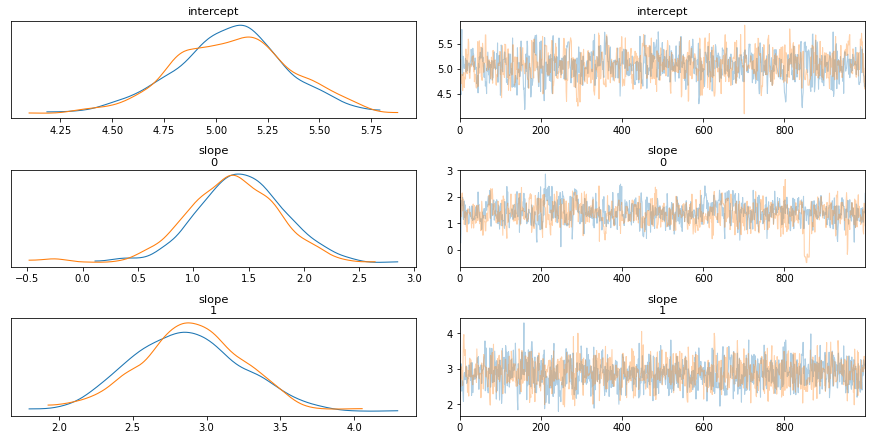

In [33]:
with mix_model:
    scalar_mixture_idata2 = az.from_pymc3(
        trace=trace, prior=prior, posterior_predictive=ppc
    )
    az.plot_trace(scalar_mixture_idata2);

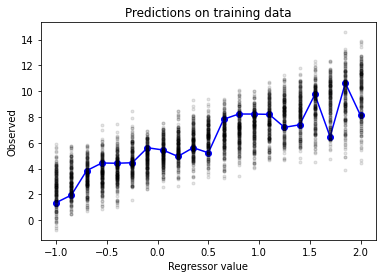

In [34]:
fig, ax = plt.subplots(1, 1)
ax.plot(x_train2, y_train2, "-ob")
ax.plot(x_train2, ppc["observed"][::10].T, ".k", alpha=0.1)
ax.set_xlabel("Regressor value")
ax.set_ylabel("Observed")
ax.set_title("Predictions on training data");

In [35]:
coords3 = coords2.copy()
coords3["obs_ind"] = np.arange(len(x_test2))
with scalar_mixture_model_factory(coords3, x_test2, y_test2):
    ppc = pm.fast_sample_posterior_predictive(trace)

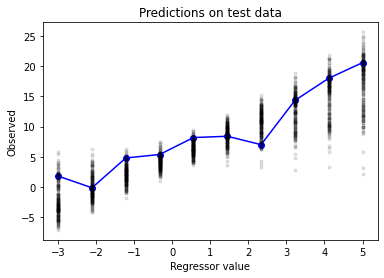

In [36]:
fig, ax = plt.subplots(1, 1)
ax.plot(x_test2, y_test2, "-ob")
ax.plot(x_test2, ppc["observed"][::10].T, ".k", alpha=0.1)
ax.set_xlabel("Regressor value")
ax.set_ylabel("Observed")
ax.set_title("Predictions on test data");

### But factory functions aren't a silver bullet

##### What happens with the latent `label`'s model?

In [37]:
def latent_label_model_factory(coords, x, y):
    with pm.Model(coords=coords) as model:
        regressor = pm.Data("x", x, dims="obs_ind")
        label = pm.Categorical("label", p=component_probability, dims="obs_ind")
        slope = pm.Normal(
            "slope",
            0,
            10,
            dims="component",
            transform=pm.transforms.Ordered(),
            testval=np.arange(len(coords2["component"])),
        )
        intercept = pm.Normal("intercept", 0, 10)
        mu = slope[label] * regressor + intercept
        output = pm.Data("y", y)
        observed = pm.Normal("observed", mu=mu, sigma=1, observed=output, dims="obs_ind")
    return model

In [38]:
with latent_label_model_factory(coords2, x_train2, y_train2) as lab_model:
    prior = pm.sample_prior_predictive()
    trace = pm.sample(tune=3000, random_seed=RANDOM_SEED)
    ppc = pm.fast_sample_posterior_predictive(trace)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>BinaryGibbsMetropolis: [label]
>NUTS: [intercept, slope]


Sampling 2 chains for 3_000 tune and 1_000 draw iterations (6_000 + 2_000 draws total) took 15 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


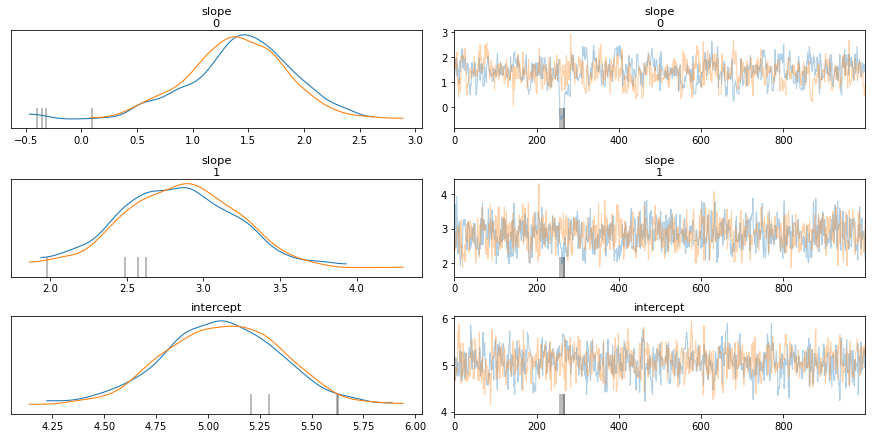

In [39]:
with lab_model:
    latent_label_idata2 = az.from_pymc3(
        trace=trace, prior=prior, posterior_predictive=ppc
    )
    az.plot_trace(latent_label_idata2, var_names=["slope", "intercept"]);

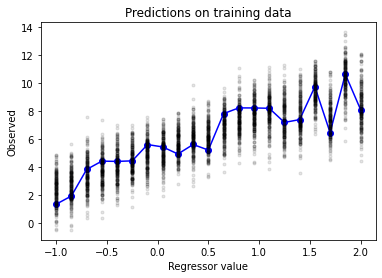

In [40]:
fig, ax = plt.subplots(1, 1)
ax.plot(x_train2, y_train2, "-ob")
ax.plot(x_train2, ppc["observed"][::10].T, ".k", alpha=0.1)
ax.set_xlabel("Regressor value")
ax.set_ylabel("Observed")
ax.set_title("Predictions on training data");

In [41]:
coords3 = coords2.copy()
coords3["obs_ind"] = np.arange(len(x_test2))
with latent_label_model_factory(coords3, x_test2, y_test2):
    try:
        ppc = pm.fast_sample_posterior_predictive(trace)
    except Exception as e:
        print(f"{e.__class__.__name__}: {e}")

ValueError: Input dimension mis-match. (input[0].shape[0] = 21, input[1].shape[0] = 10)
Apply node that caused the error: Elemwise{Composite{((i0 * i1) + i2)}}[(0, 0)](AdvancedSubtensor1.0, x, InplaceDimShuffle{x}.0)
Toposort index: 10
Inputs types: [TensorType(float64, vector), TensorType(float64, vector), TensorType(float64, (True,))]
Inputs shapes: [(21,), (10,), (1,)]
Inputs strides: [(8,), (8,), (8,)]
Inputs values: ['not shown', 'not shown', array([4.88740254])]
Outputs clients: [['output']]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.


### We have to manually trim the inferred posterior

In [42]:
trace["label"].shape[-1]

21

The shape (and values) of the __inferred labels__ is determined by the training data!

To make predictions on new data we need to remove any samples for the `label` RV from the trace.

In [43]:
trace.remove_values("label")  # This is done inplace!

In [44]:
coords3 = coords2.copy()
coords3["obs_ind"] = np.arange(len(x_test2))
with latent_label_model_factory(coords3, x_test2, y_test2):
    ppc = pm.fast_sample_posterior_predictive(trace)

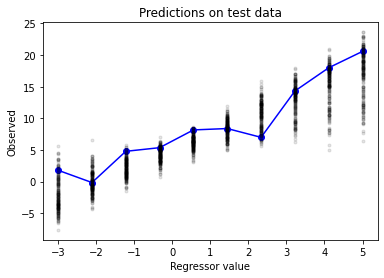

In [45]:
fig, ax = plt.subplots(1, 1)
ax.plot(x_test2, y_test2, "-ob")
ax.plot(x_test2, ppc["observed"][::10].T, ".k", alpha=0.1)
ax.set_xlabel("Regressor value")
ax.set_ylabel("Observed")
ax.set_title("Predictions on test data");

## Why is sampling from the posterior predictive so hard?

- When it was first designed, `pymc3` focused on posterior inference
- `theano` is only used to build the model's `logp`
- `Distribution`s mix `theano` symbolic tensor parameters outside of the `theano` computational graph
- Prior and posterior predictive sampling use `Distribution.random`

`random` does a sort of ping-pong between running partial `theano` functions and calling `scipy.stats` random number generators

```python
class Distribution:
    ...
    def random(self, point=None, size=None):
        parameter_values = draw_values(self._distribution_parameters, point, size)
        return use_scipy_to_generate_random_values(parameter_values, size, ...)
```

### Problems

- Theano runtime tensor shapes are not available to `random` 
- Distributions cannot adapt their `shape` at runtime
- Distributions cannot infer their `shape` implied by their parameters at build time

### What can we do to help?

- Go full symbolic: https://github.com/pymc-devs/symbolic-pymc
- Contributions welcome to adopting the fully symbolical `RandomVariable` `Op` into `pymc3`

# Thank you for your attention!